In [33]:
### Creating Combat Log Table

In [34]:
# what needs to happen is that a table needs to be created that stores each turn in combat and the actions that happened in that turn.
# the table should have the following columns:

# create the table in the form of a dataframe
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


# create the table
combat_log = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Number',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])

In [35]:
import Species
import Backgrounds
import Armor_and_Weapons
import Dice_Rolls
import Establishing_Hierarchy
import CHARACTER_CREATOR
import Monsters

import Character_Actions

In [36]:
def generate_situation(character_num):
    print('generating situation...')

    # for the number of characters, randomly generate a Player_Character using Random_Character()
    entities = []
    print('generating characters...')
    for i in range(character_num):
        entities.append(CHARACTER_CREATOR.Random_Character())

    # for the number of entities, within each entity's flesh out the Active_Conditions and Circumstances dictionaries
    for entity in range(len(entities)):
        other_entities = entities.copy()
        other_entities.pop(entity)
        
        self_name = str(entities[entity].Name)
        entities[entity].Circumstances['Attack Rolls'][self_name] = None
        # I want to add a key for each other entity in the Active_Conditions dictionaries
        for other_entity in range(len(other_entities)):
            entities[entity].Active_Conditions[str(entities[other_entity])] = []
            other_entity_name = str(other_entities[other_entity].Name)
            entities[entity].Circumstances['Attack Rolls'][other_entity_name] = None

            #entities[entity].Circumstances['Attack Rolls'][entity_name] = 'placeholder'
            #print(entities[other_entity].Name)
    return entities


def generate_combat(character_num):
    print('generating combat...')

    combat_log_new = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])
    # create situation
    combat_situation = generate_situation(character_num)
    

    print('adding action options...')
    for entity in range(len(combat_situation)):
        combat_situation[entity].Actions['None'] = Character_Actions.No_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Bonus_Actions['None'] = Character_Actions.No_Bonus_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Attack'] = Character_Actions.Attack_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Dodge'] = Character_Actions.Dodge_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Help'] = Character_Actions.Help_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Free_Actions['Move'] = Character_Actions.Move(combat_situation[entity],combat_situation,combat_log_new)
        Character_Actions.Equip_Weapon(combat_situation[entity],Character_Actions.Choose_Random_Weapon(combat_situation[entity]))

        # assign a unique location to each entity within a 12x12 grid
        combat_situation[entity].Location['X'] = np.random.randint(0,12)
        combat_situation[entity].Location['Y'] = np.random.randint(0,12)
        combat_situation[entity].Location['Z'] = 0
    
    # print the locations of each creature using a plot
    print('plotting locations...')
    plt.figure(figsize=(12,12))
    for entity in range(len(combat_situation)):
        plt.scatter(combat_situation[entity].Location['X'],combat_situation[entity].Location['Y'],label=combat_situation[entity].Name)
    plt.legend()
    plt.grid(True)
    plt.xlim(0,12)
    plt.ylim(0,12)
    plt.show()

    combat_round = 0
    combat_log_new['Combat Round'] = combat_round
    

    def take_turn(combat_log_new,character):
        # need to decide which action_type to take first: Actions or Bonus_Actions
        action_types = ['Actions','Bonus_Actions','Movement']
            # Move Splitting
            # Free Action
            # Object Interaction
        first_action_type = np.random.choice(action_types)
        # choose a second action type from the list minus the first action type
        second_action_type = np.random.choice([action for action in action_types if action != first_action_type])
        third_action_type = np.random.choice([action for action in action_types if action != first_action_type and action != second_action_type])

        if first_action_type == 'Actions':
            first_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = combat_situation[character].Actions[first_action]
        elif first_action_type == 'Bonus_Actions':
            first_action = np.random.choice(['None'])
            new_turn = combat_situation[character].Bonus_Actions[first_action]
        elif first_action_type == 'Movement':
            new_turn = combat_situation[character].Free_Actions['Move']
                
        if second_action_type == 'Actions':
            second_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Bonus_Actions':
            second_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)        
        
        if third_action_type == 'Actions':
            third_action = np.random.choice(['None','Attack','Dodge','Help'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Bonus_Actions':
            third_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)            



        #new_round = combat_situation[character].first_action_type[first_action]
        #new_round = pd.concat([new_round, combat_situation[character].second_action_type[second_action]], ignore_index=True, axis=0)


        #action = np.random.choice(['None','Attack','Dodge'])
        #bonus_action = np.random.choice(['None'])
        #new_round = combat_situation[character].Actions[action]
        #combat_log_new = pd.concat([combat_log_new, new_round], ignore_index=True, axis=0)
        return new_turn
    
    # making a round 0 to represent the spawning conditions
    first_row = pd.DataFrame({'Combat Round':0,
                                                              'Action Time': None,
                                                              'Action Name': None, 
                                                              'Action Type': None,
                                                              'Target': None,
                                                              'Action Result': None,
                                                              'Current Allied Ability Check':'Spawning','Current Allied Attack Roll':'Spawning','Current Allied Saving Throw':'Spawning','Current Allied Damage Roll':'Spawning','Current Enemy Ability Check':'Spawning','Current Enemy Attack Roll':'Spawning','Current Enemy Saving Throw':'Spawning','Current Enemy Damage Roll':'Spawning'}, index=[0])

    for entity in range(len(combat_situation)):
        first_row[combat_situation[entity].Name + ' Acting True'] = 0
        first_row[combat_situation[entity].Name + ' Current_HP'] = combat_situation[entity].Current_HP
        first_row[combat_situation[entity].Name + ' Temp_HP'] = combat_situation[entity].Temp_HP
        first_row[combat_situation[entity].Name + ' Size'] = combat_situation[entity].Size
        first_row[combat_situation[entity].Name + ' Walking Speed'] = combat_situation[entity].Speed['Walking']
        first_row[combat_situation[entity].Name + ' Flying Speed'] = combat_situation[entity].Speed['Flying']
        first_row[combat_situation[entity].Name + ' Str_Score'] = combat_situation[entity].Str_Score
        first_row[combat_situation[entity].Name + ' Dex_Score'] = combat_situation[entity].Dex_Score
        first_row[combat_situation[entity].Name + ' Con_Score'] = combat_situation[entity].Con_Score
        first_row[combat_situation[entity].Name + ' Int_Score'] = combat_situation[entity].Int_Score
        first_row[combat_situation[entity].Name + ' Wis_Score'] = combat_situation[entity].Wis_Score
        first_row[combat_situation[entity].Name + ' Cha_Score'] = combat_situation[entity].Cha_Score
        first_row[combat_situation[entity].Name + ' Active_Conditions'] = combat_situation[entity].Active_Conditions
        first_row[combat_situation[entity].Name + ' Concentrating'] = combat_situation[entity].Concentrating
        first_row[combat_situation[entity].Name + 'Location X'] = combat_situation[entity].Location['X']
        first_row[combat_situation[entity].Name + 'Location Y'] = combat_situation[entity].Location['Y']
        first_row[combat_situation[entity].Name + 'Location Z'] = combat_situation[entity].Location['Z']

    # attach the new_round dictionary to the combat_log_new dataframe using concat
    combat_log_new = pd.concat([combat_log_new,pd.DataFrame(first_row)],ignore_index=False)

    for character in range(len(combat_situation)):
        # print their starting health
        print('Character: ' + combat_situation[character].Name + ' has ' + str(combat_situation[character].Current_HP) + ' HP')

    print('taking turns...')
    for Combat_Round in range(1,10):
        combat_round += 1

        for entity in range(len(combat_situation)):
            combat_log_new = pd.concat([combat_log_new,take_turn(combat_log_new,entity)], ignore_index=True, axis=0)


    combat_log_new = combat_log_new.reindex(columns=['Combat Round'] + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Acting True')]) + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Current_HP')]) + list(combat_log_new.columns[1:][~combat_log_new.columns[1:].str.contains('Acting True') & ~combat_log_new.columns[1:].str.contains('Current_HP')]))
    
    return combat_log_new


In [37]:
# remove the number of columns limit
pd.set_option('display.max_columns', None)

generating combat...
generating situation...
generating characters...
Character_Creator - Random Character Function - Class Choice:  <module 'Barbarian' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Barbarian.py'>
Create Character Function - Class: <module 'Barbarian' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Barbarian.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choi

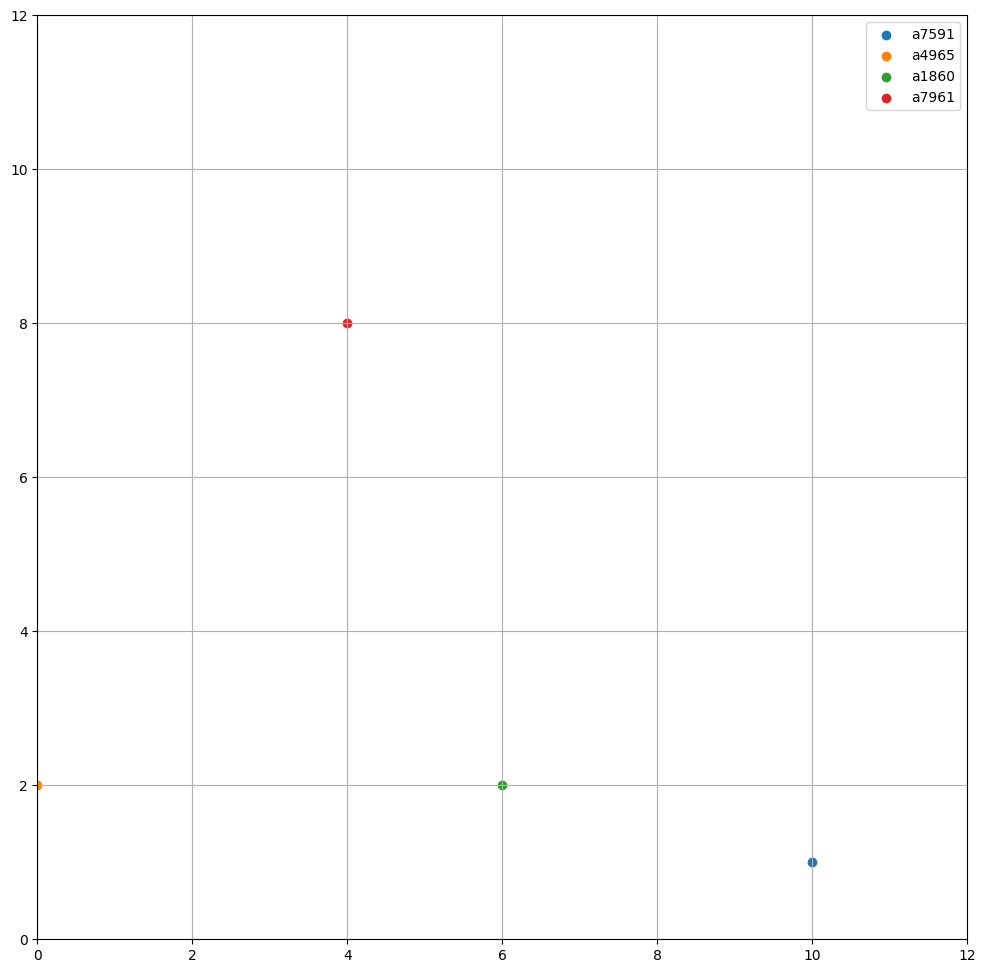

Character: a7591 has 10 HP
Character: a4965 has 11 HP
Character: a1860 has 9 HP
Character: a7961 has 4.0 HP
taking turns...


In [38]:
combat_log_new = generate_combat(4)

In [39]:
combat_log_new

,Combat Round,a7591 Acting True,a4965 Acting True,a1860 Acting True,a7961 Acting True,a7591 Current_HP,a4965 Current_HP,a1860 Current_HP,a7961 Current_HP,Action Time,Action Name,Action Type,Target,Action Result,Current Allied Ability Check,Current Allied Attack Roll,Current Allied Saving Throw,Current Allied Damage Roll,Current Enemy Ability Check,Current Enemy Attack Roll,Current Enemy Saving Throw,Current Enemy Damage Roll,a7591 Temp_HP,a7591 Size,a7591 Walking Speed,a7591 Flying Speed,a7591 Str_Score,a7591 Dex_Score,a7591 Con_Score,a7591 Int_Score,a7591 Wis_Score,a7591 Cha_Score,a7591 Active_Conditions,a7591 Concentrating,a7591Location X,a7591Location Y,a7591Location Z,a4965 Temp_HP,a4965 Size,a4965 Walking Speed,a4965 Flying Speed,a4965 Str_Score,a4965 Dex_Score,a4965 Con_Score,a4965 Int_Score,a4965 Wis_Score,a4965 Cha_Score,a4965 Active_Conditions,a4965 Concentrating,a4965Location X,a4965Location Y,a4965Location Z,a1860 Temp_HP,a1860 Size,a1860 Walking Speed,a1860 Flying Speed,a1860 Str_Score,a1860 Dex_Score,a1860 Con_Score,a1860 Int_Score,a1860 Wis_Score,a1860 Cha_Score,a1860 Active_Conditions,a1860 Concentrating,a1860Location X,a1860Location Y,a1860Location Z,a7961 Temp_HP,a7961 Size,a7961 Walking Speed,a7961 Flying Speed,a7961 Str_Score,a7961 Dex_Score,a7961 Con_Score,a7961 Int_Score,a7961 Wis_Score,a7961 Cha_Score,a7961 Active_Conditions,a7961 Concentrating,a7961Location X,a7961Location Y,a7961Location Z
0,0,0.0,0.0,0.0,0.0,10.0,11.0,9.0,4.0,None,None,None,None,None,Spawning,Spawning,Spawning,Spawning,Spawning,Spawning,Spawning,Spawning,0.0,Medium,30.0,0.0,14.0,15.0,12.0,8.0,13.0,12.0,NaN,False,10.0,1.0,0.0,0.0,Medium,30.0,0.0,10.0,12.0,13.0,8.0,14.0,15.0,NaN,False,0.0,2.0,0.0,0.0,Medium,30.0,0.0,14.0,12.0,8.0,10.0,15.0,13.0,NaN,False,6.0,2.0,0.0,0.0,Medium,30.0,0.0,8.0,13.0,14.0,15.0,10.0,14.0,NaN,False,4.0,8.0,0.0
1,0,1.0,0.0,0.0,0.0,10.0,11.0,9.0,11.0,Bonus Action,None,Passive,a7591,None,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,0.0,Medium,30.0,0.0,14.0,15.0,12.0,8.0,13.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,12.0,13.0,8.0,14.0,15.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,14.0,12.0,8.0,10.0,15.0,13.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,8.0,13.0,14.0,15.0,10.0,14.0,NaN,False,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,10.0,11.0,9.0,11.0,Move,Move,Mobility,a7591,Moved,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,0.0,Medium,30.0,0.0,14.0,15.0,12.0,8.0,13.0,12.0,NaN,False,8.0,7.0,0.0,0.0,Medium,30.0,0.0,10.0,12.0,13.0,8.0,14.0,15.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,14.0,12.0,8.0,10.0,15.0,13.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,8.0,13.0,14.0,15.0,10.0,14.0,NaN,False,0.0,0.0,0.0
3,0,1.0,0.0,0.0,0.0,10.0,11.0,9.0,11.0,Action,Dodge,Defense,a7591,Dodge,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,<Dice_Rolls.Ability_Check object at 0x0000017E...,<Dice_Rolls.Attack_Roll object at 0x0000017E4F...,<Dice_Rolls.Saving_Throw object at 0x0000017E4...,<Dice_Rolls.Damage_Roll object at 0x0000017E4F...,0.0,Medium,30.0,0.0,14.0,15.0,12.0,8.0,13.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,10.0,12.0,13.0,8.0,14.0,15.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0

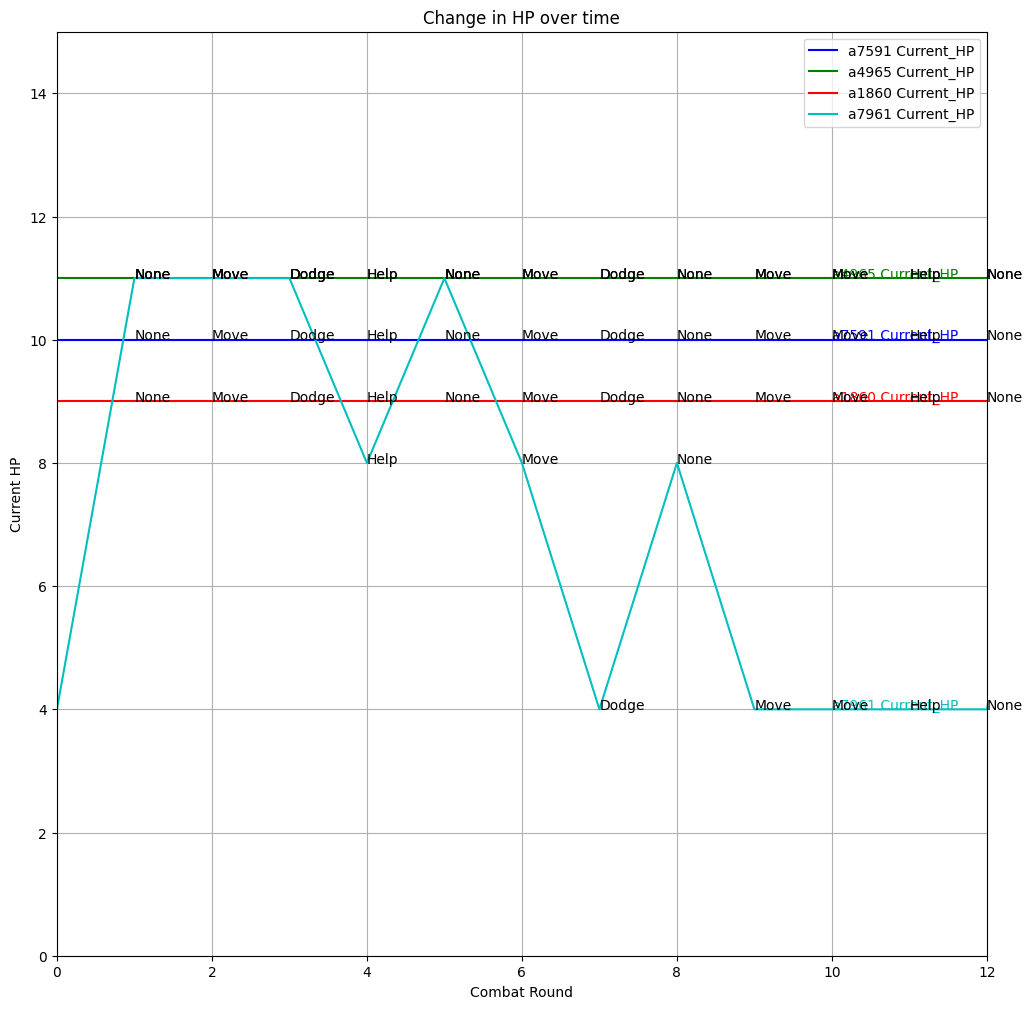

In [40]:
# plot the change in HP over time for each character
# first reduce combat_log_new to just the columns that contain 'Current_HP'
# then plot the change in HP over time for each character
combat_log_new_HP = combat_log_new.loc[:, combat_log_new.columns.str.contains('Current_HP')]
# use a different color per character
colors = ['b','g','r','c']
plt.figure(figsize=(12,12))
for character in range(len(combat_log_new_HP.columns)):
    plt.plot(combat_log_new_HP[combat_log_new_HP.columns[character]],color=colors[character],label=combat_log_new_HP.columns[character])
plt.legend()
plt.grid(True)
# add data labels for the characters
for character in range(len(combat_log_new_HP.columns)):
    plt.text(10,combat_log_new_HP[combat_log_new_HP.columns[character]].iloc[-1],combat_log_new_HP.columns[character],color=colors[character])
plt.xlabel('Combat Round')
plt.ylabel('Current HP')
plt.title('Change in HP over time')
plt.xlim(0,12)
plt.ylim(0,15)
# add data labels for which actions the characters took in each round using new_combat_log
for i in range(len(combat_log_new)):
    # for each character
    for character in range(len(combat_log_new_HP.columns)):
        # if the character's HP is at its highest in that round
        if combat_log_new_HP[combat_log_new_HP.columns[character]].iloc[i] == combat_log_new_HP[combat_log_new_HP.columns[character]].iloc[i].max():
            # put the action label at the height of the character's HP at that time
            plt.text(i,combat_log_new_HP[combat_log_new_HP.columns[character]].iloc[i],combat_log_new['Action Name'].iloc[i])
    # put the action label at the height of the character's HP at that time
    plt.text(i,combat_log_new_HP.iloc[i].max(),combat_log_new['Action Name'].iloc[i])
    # limit to the same limit as the x-axis
    if i > 11:
        break
plt.show()